In [101]:
import pandas as pd
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from gensim import corpora, models

Trying to separate the video searches to their appropriate companies

In [10]:
df1 = pd.read_excel('youtube_data_latest.xlsx', sheet_name=0)
df2 = pd.read_excel('youtube_data_latest.xlsx', sheet_name=1)

Associating the comments and videos to their appropriate companies

In [6]:
company_keywords = {
    'Abarth': ['Abarth', 'abarth', 'ABARTH'],
    'Fiat': ['Fiat', 'fiat', 'FIAT'],
    'Mini': ['Mini', 'mini', 'MINI'],
    'Peugeot': ['Peugeot', 'peugeot', 'PEUGEOT'],
    'Volkswagen': ['Volkswagen', 'volkswagen', 'VW', 'vw', 'Vw'],
    'Tesla': ['Tesla', 'tesla', 'TESLA']
}

def assign_company(row):
    for company, keywords in company_keywords.items():
        if any(keyword in str(row['Post_Title']) or keyword in str(row['Post_Content']) for keyword in keywords):
            return company
    return 'Unknown'

df1['Company'] = df1.apply(assign_company, axis=1)

In [9]:
df1[df1['Company'] == 'Unknown'].head()

,Post_id,Post_Title,Author,Date,Post_Content,Comment_Number,Net_Like,Views,Company
53,GI9pkcFJXV4,All about the Taurozzi Pendulum Engine 🧠 and w...,Repairman22,2023-01-21T14:00:08Z,In this video we analyze the Taurozzi pendulum...,2371,31430,1540034,Unknown
54,9lse1SfDq7M,Engine lubrication system / How does it work? ...,CARinfo3d (En),2022-12-07T13:47:38Z,The internal combustion engine contains numero...,66,4153,165024,Unknown
60,W94iksaQwUo,How Ignition System Works,Automotive System,2012-08-13T12:55:59Z,Know the basic working of an automobile igniti...,949,32122,4814980,Unknown
61,90uUdwJBEu4,Learn about every Engine Layout in just one vi...,The Engineers Post,2023-01-02T13:16:16Z,Straight/Inline engine:\nThe straight or inlin...,204,7424,380541,Unknown
64,x70VqMrXrbs,Car Engine Parts & Their Functions Explained i...,The Engineers Post,2021-04-17T11:39:00Z,List of Car Engine Parts | TheEngineersPost\n\...,793,109477,4054744,Unknown


Combining df2 to locate comments with Unknown company, labeled in df1

In [5]:
#Mapping to df2 to remove unwanted video comments
merged_df2 = df2.merge(df1[['Post_id', 'Company']], on='Post_id', how='left')

In [6]:
#Checking the length of the Unknown in df1 and df2
print(df1[df1['Company'] == 'Unknown']['Comment_Number'].sum())
print(len(merged_df2[merged_df2['Company']=='Unknown']))

44820
33630


In [12]:
#Dropping the NaN values
merged_df1 = df1[df1['Company'] != 'Unknown']
merged_df2 = merged_df2.dropna(subset=['Comment_Content'])

**Dealing with different languages**

In [14]:
#Library is used for detecting the language
from langdetect import detect

#Function used for running the comments through to detect the language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

#Creates a new column 'language' in merged_df2 to detect the language in the comment
merged_df2['language'] = merged_df2['Comment_Content'].apply(detect_language)

In [34]:
merged_df2.head()

,Unique_id,Post_id,Author,Date,Comment_Content,Reply_id,Company,language
0,UgwxZe_9rq6Divz2B6V4AaABAg,eQlcDSnItRk,Tomas Juricek,2023-05-27T08:14:43Z,Not more car,0,Abarth,ro
1,UgyaJ0l-wY032jA6YsR4AaABAg,eQlcDSnItRk,Todd Turner,2023-05-21T12:25:06Z,If Hydrocarbons came from dinosaurs how many o...,0,Abarth,en
2,Ugxp60x3am7lNpJjYt94AaABAg,eQlcDSnItRk,PoltergeistWorks,2023-05-20T19:08:31Z,"Less power, less range, fake noise and twice t...",0,Abarth,en
3,UgxfZcCbo05HhzRi1Ht4AaABAg,eQlcDSnItRk,Spooligan,2023-05-17T10:54:08Z,TF?!? 96mph? A prius does 0 to 60 faster than ...,0,Abarth,en
4,UgxZboo7_6pqKXGUAt94AaABAg,eQlcDSnItRk,Miguel Afonso,2023-05-16T22:44:14Z,"Even slower that a 595 I reckon, and you can h...",0,Abarth,en


In [1]:
#Saving the file
#merged_df1.to_csv('merged_df1___.csv', index=False)
#merged_df2.to_csv('merged_df2___.csv', index=False)

LOADING THE LATEST FILES

In [113]:
#Loading the file
merged_df1 = pd.read_csv('merged_df1.csv')
merged_df2 = pd.read_csv('merged_df2.csv')

In [114]:
print(len(merged_df1[merged_df1['Company']=='Unknown']))

0


In [115]:
len(merged_df2)

181877

Dropping unknown, duplicates and non English comments

In [116]:
#Dropping the unknown company comments, a lot unrelated
merged_df1 = merged_df1[merged_df1['Company'] != 'Unknown']
merged_df2 = merged_df2[merged_df2['Company'] != 'Unknown']

In [117]:
#Seaparating the english and non-english comments
english_comments = merged_df2[merged_df2['language'] == 'en']
non_english_comments = merged_df2[merged_df2['language'] != 'en']

# Removing the duplicated words
english_comments = english_comments.drop_duplicates(subset=['Comment_Content'])
non_english_comments = non_english_comments.drop_duplicates(subset=['Comment_Content'])

In [118]:
#For all the data within merged_df2
print(len(english_comments) + len(non_english_comments))
print(len(english_comments))
print(len(non_english_comments))

123118
103190
19928


In [125]:
english_comments.head()

,Unique_id,Post_id,Author,Date,Comment_Content,Reply_id,Company,language
1,UgyaJ0l-wY032jA6YsR4AaABAg,eQlcDSnItRk,Todd Turner,2023-05-21T12:25:06Z,If Hydrocarbons came from dinosaurs how many o...,0,Abarth,en
2,Ugxp60x3am7lNpJjYt94AaABAg,eQlcDSnItRk,PoltergeistWorks,2023-05-20T19:08:31Z,"Less power, less range, fake noise and twice t...",0,Abarth,en
3,UgxfZcCbo05HhzRi1Ht4AaABAg,eQlcDSnItRk,Spooligan,2023-05-17T10:54:08Z,TF?!? 96mph? A prius does 0 to 60 faster than ...,0,Abarth,en
4,UgxZboo7_6pqKXGUAt94AaABAg,eQlcDSnItRk,Miguel Afonso,2023-05-16T22:44:14Z,"Even slower that a 595 I reckon, and you can h...",0,Abarth,en
6,UgwUDsWCgDBFgrMYtGJ4AaABAg,eQlcDSnItRk,DAADs Reviews,2023-05-06T07:44:04Z,Id modify mine for a bigger battery pack if it...,0,Abarth,en


In [122]:
from collections import Counter
import pandas as pd

#Top 20 words

# Concatenating all the comments into one big string
all_comments = ' '.join(english_comments['Comment_Content'])

# Tokenizing the text into individual words
words = all_comments.split()

# Using Counter to count occurrences of each word
word_counts = Counter(words)

# Finding the 10 most common words
top_twenty_words = word_counts.most_common(20)


In [123]:
top_twenty_words_only = [word for word, count in top_twenty_words]
top_twenty_words_only

['the',
 'a',
 'to',
 'and',
 'is',
 'I',
 'of',
 'in',
 'it',
 'for',
 'you',
 'that',
 'this',
 'on',
 'car',
 'with',
 'be',
 'have',
 'are',
 'like']

**After separating the languages, here comes the NLP pre-processing stage**

In [124]:
import spacy
import string

# Load Spacy model
nlp = spacy.load('en_core_web_sm')

In [126]:
def clean_text(text):
    # Parse the text with SpaCy. This runs the entire pipeline.
    doc = nlp(text)
    
    # 'd' contains the difference between set of all characters and the set of punctuations
    d = set(string.printable) - set(string.punctuation)

    # create a new list to hold the modified tokens
    new_tokens = []

    i = 0
    while i < len(doc):
        # If the current token is 'not' and the next token exists
        if doc[i].lemma_ == 'not' and i < len(doc) - 1:
            # append the next token text preceded by 'not_'
            new_tokens.append('not_' + doc[i+1].text)
            # increment i by 2 to skip the next token
            i += 2
        else:
            # otherwise, append the current token lemma
            new_tokens.append(doc[i].lemma_)
            # increment i by 1 to move to the next token
            i += 1

    # Filter tokens that are stop words or punctuation symbols and that are not in the printable set of characters
    tokens = [token for token in new_tokens if not nlp.vocab[token].is_stop and not nlp.vocab[token].is_punct and all([ch in d for ch in token])]
    
    # Lowercase, lemmatize, and remove non-alphabetic characters
    cleaned_tokens = [token.lower() for token in tokens if token.isalpha()]

    # Additional stop words list
    additional_stopwords = ['car', 'like', 'go', 'vehicle', 'to', 'abarth', 'andy', 'need', 'want', 'think', 'yeah', 'way', 'lol', 'fiat',
                            'vw', 'volkswagen', 'peugeot','mini', 'tesla', 'honda', 'bmw', 'chrysler', 'toyota', 'people', 'know', 'come', 
                            'maybe', 'thing', 'time', 'start', 'right', 'little', 'new', 'vs'] + top_twenty_words_only
    cleaned_tokens = [token for token in cleaned_tokens if token not in additional_stopwords]
    
    
    # Join cleaned tokens back into a string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [127]:
# Apply preprocessing to each comment
english_comments['Comment_Content'] = english_comments['Comment_Content'].apply(clean_text)

In [128]:
#Checking how many companies are there
unique_companies = english_comments['Company'].unique()
for company in unique_companies:
    print(company)

Abarth
Fiat
Tesla
Mini
Volkswagen
Peugeot


Making individual dataframes for each companies

In [129]:
#Separating the dataframe to their companies
Abarth = english_comments[english_comments['Company']=='Abarth']
Fiat= english_comments[english_comments['Company']=='Fiat']
Tesla= english_comments[english_comments['Company']=='Tesla']
Mini= english_comments[english_comments['Company']=='Mini']
Volkswagen= english_comments[english_comments['Company']=='Volkswagen']
Peugeot= english_comments[english_comments['Company']=='Peugeot']

In [130]:
#Making all these comments to list
Abarth_comments = Abarth['Comment_Content'].tolist()
Fiat_comments = Fiat['Comment_Content'].tolist()
Tesla_comments = Tesla['Comment_Content'].tolist()
Mini_comments = Mini['Comment_Content'].tolist()
Volkswagen_comments = Volkswagen['Comment_Content'].tolist()
Peugeot_comments = Peugeot['Comment_Content'].tolist()

Constructing the ngrams

In [131]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Tokenize the comments
Abarth_comments = list(sent_to_words(Abarth['Comment_Content']))
Fiat_comments = list(sent_to_words(Fiat['Comment_Content']))
Tesla_comments = list(sent_to_words(Tesla['Comment_Content']))
Mini_comments = list(sent_to_words(Mini['Comment_Content']))
Volkswagen_comments = list(sent_to_words(Volkswagen['Comment_Content']))
Peugeot_comments = list(sent_to_words(Peugeot['Comment_Content']))

In [132]:
# Train the bigram models
bigram = Phrases(Abarth_comments + Fiat_comments + Tesla_comments + Mini_comments + Volkswagen_comments + Peugeot_comments, min_count=5, threshold=10) # higher threshold fewer phrases.

In [133]:
# Get a sentence clubbed as a bigram
bigram_mod = Phraser(bigram)

In [134]:
def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

In [135]:
# Form Bigrams
Abarth_comments_bigrams = make_bigrams(Abarth_comments, bigram_mod)
Fiat_comments_bigrams = make_bigrams(Fiat_comments, bigram_mod)
Tesla_comments_bigrams = make_bigrams(Tesla_comments, bigram_mod)
Mini_comments_bigrams = make_bigrams(Mini_comments, bigram_mod)
Volkswagen_comments_bigrams = make_bigrams(Volkswagen_comments, bigram_mod)
Peugeot_comments_bigrams = make_bigrams(Peugeot_comments, bigram_mod)

Making dictionary to map integer ids and the words

In [136]:
def create_dict_corpus(texts):
    # Create Dictionary
    id2word = corpora.Dictionary(texts)
    
    # Create Corpus
    texts = texts
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return id2word, corpus

In [137]:
#This utilises the brigrams
Abarth_id2word, Abarth_corpus = create_dict_corpus(Abarth_comments_bigrams)
Fiat_id2word, Fiat_corpus = create_dict_corpus(Fiat_comments_bigrams)
Tesla_id2word, Tesla_corpus = create_dict_corpus(Tesla_comments_bigrams)
Mini_id2word, Mini_corpus = create_dict_corpus(Mini_comments_bigrams)
Volkswagen_id2word, Volkswagen_corpus = create_dict_corpus(Volkswagen_comments_bigrams)
Peugeot_id2word, Peugeot_corpus = create_dict_corpus(Peugeot_comments_bigrams)

Creating the LDA model for each of the company

In [138]:
import gensim
from gensim.models.coherencemodel import CoherenceModel

def create_lda_models_with_coherence(id2word, corpus, texts, min_topics=5, max_topics=15):
    coherence_values = []
    for num_topics in range(min_topics, max_topics):
        print('Round:', num_topics)
        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        
        cm = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append((num_topics, cm.get_coherence()))

    return lda_model, coherence_values


In [141]:
from gensim.models.coherencemodel import CoherenceModel

def create_lda_models_with_coherence(id2word, corpus, texts, min_topics=3, max_topics=10):
    max_coherence = 0
    best_lda_model = None
    coherence_values = []

    for num_topics in range(min_topics, max_topics):
        print('Round:', num_topics)
        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        
        cm = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append((num_topics, cm.get_coherence()))
        coherence = cm.get_coherence()

        if coherence > max_coherence:
            max_coherence = coherence
            best_lda_model = lda_model

    return best_lda_model, coherence_values, max_coherence

In [142]:
Abarth_lda_model, Abarth_C, Abarth_max = create_lda_models_with_coherence(Abarth_id2word, Abarth_corpus, Abarth_comments_bigrams)
Fiat_lda_model, Fiat_C, Fiat_max = create_lda_models_with_coherence(Fiat_id2word, Fiat_corpus, Fiat_comments_bigrams)
Tesla_lda_model, Tesla_C, Tesla_max = create_lda_models_with_coherence(Tesla_id2word, Tesla_corpus, Tesla_comments_bigrams)
Mini_lda_model, Mini_C, Mini_max = create_lda_models_with_coherence(Mini_id2word, Mini_corpus, Mini_comments_bigrams)
Volkswagen_lda_model, Volk_C, Volk_max = create_lda_models_with_coherence(Volkswagen_id2word, Volkswagen_corpus, Volkswagen_comments_bigrams)
Peugeot_lda_model, Peugeot_C, Peugeot_max = create_lda_models_with_coherence(Peugeot_id2word, Peugeot_corpus, Peugeot_comments_bigrams)

Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9


In [143]:
Abarth_topics = Abarth_lda_model.print_topics(num_words=6)
for topic in Abarth_topics:
    print(topic)

(0, '0.059*"sound" + 0.056*"ev" + 0.043*"engine" + 0.042*"electric" + 0.029*"drive" + 0.026*"range"')
(1, '0.045*"small" + 0.022*"sell" + 0.021*"cool" + 0.015*"light" + 0.015*"performance" + 0.014*"road"')
(2, '0.073*"love" + 0.028*"model" + 0.023*"charge" + 0.019*"lot" + 0.017*"system" + 0.016*"cost"')
(3, '0.081*"look" + 0.050*"good" + 0.037*"great" + 0.031*"buy" + 0.030*"fun" + 0.026*"nice"')
(4, '0.043*"battery" + 0.034*"video" + 0.033*"year" + 0.018*"run" + 0.017*"hybrid" + 0.015*"idea"')
(5, '0.032*"design" + 0.024*"italian" + 0.023*"usa" + 0.021*"hate" + 0.018*"fast" + 0.018*"stellantis"')
(6, '0.033*"hope" + 0.032*"work" + 0.030*"review" + 0.026*"mile" + 0.020*"bring" + 0.019*"try"')
(7, '0.027*"expensive" + 0.026*"thank" + 0.024*"brand" + 0.018*"world" + 0.018*"end" + 0.016*"far"')


In [144]:
Mini_topics = Mini_lda_model.print_topics(num_words=6)
for topic in Mini_topics:
    print(topic)

(0, '0.021*"small" + 0.014*"lot" + 0.013*"engine" + 0.010*"build" + 0.009*"weight" + 0.009*"quality"')
(1, '0.054*"look" + 0.026*"price" + 0.025*"design" + 0.018*"electric" + 0.015*"motor" + 0.013*"buy"')
(2, '0.028*"battery" + 0.026*"ev" + 0.017*"good" + 0.017*"love" + 0.016*"range" + 0.013*"great"')


In [145]:
Tesla_topics = Tesla_lda_model.print_topics(num_words=6)
for topic in Tesla_topics:
    print(topic)

(0, '0.038*"use" + 0.033*"battery" + 0.025*"power" + 0.018*"water" + 0.016*"charge" + 0.014*"run"')
(1, '0.046*"ev" + 0.017*"future" + 0.016*"buy" + 0.012*"ice" + 0.011*"technology" + 0.010*"problem"')
(2, '0.118*"hydrogen" + 0.043*"engine" + 0.034*"electric" + 0.021*"fuel" + 0.018*"good" + 0.013*"gas"')


In [146]:
Mini_topics = Mini_lda_model.print_topics(num_words=6)
for topic in Mini_topics:
    print(topic)

(0, '0.021*"small" + 0.014*"lot" + 0.013*"engine" + 0.010*"build" + 0.009*"weight" + 0.009*"quality"')
(1, '0.054*"look" + 0.026*"price" + 0.025*"design" + 0.018*"electric" + 0.015*"motor" + 0.013*"buy"')
(2, '0.028*"battery" + 0.026*"ev" + 0.017*"good" + 0.017*"love" + 0.016*"range" + 0.013*"great"')


In [147]:
Volk_topics = Volkswagen_lda_model.print_topics(num_words=6)
for topic in Volk_topics:
    print(topic)

(0, '0.031*"drive" + 0.014*"software" + 0.013*"golf" + 0.013*"great" + 0.011*"lot" + 0.010*"bad"')
(1, '0.031*"electric" + 0.030*"range" + 0.022*"battery" + 0.019*"use" + 0.017*"buy" + 0.015*"love"')
(2, '0.052*"look" + 0.028*"good" + 0.018*"review" + 0.018*"design" + 0.018*"video" + 0.016*"interior"')
(3, '0.063*"ev" + 0.030*"year" + 0.014*"hope" + 0.012*"market" + 0.012*"road" + 0.012*"yes"')


In [148]:
Peugeot_topics = Peugeot_lda_model.print_topics(num_words=6)
for topic in Peugeot_topics:
    print(topic)

(0, '0.105*"love" + 0.031*"big" + 0.023*"wheel" + 0.020*"hope" + 0.017*"definitely" + 0.017*"great_review"')
(1, '0.119*"look" + 0.058*"design" + 0.036*"nice" + 0.030*"suv" + 0.021*"headlight" + 0.020*"version"')
(2, '0.043*"engine" + 0.032*"bad" + 0.024*"day" + 0.020*"compare" + 0.019*"early" + 0.016*"quality"')
(3, '0.078*"mat" + 0.071*"carwow" + 0.024*"comment" + 0.022*"yes" + 0.021*"guy" + 0.021*"amazing"')
(4, '0.028*"bit" + 0.025*"second" + 0.023*"close" + 0.019*"road" + 0.019*"water" + 0.017*"local"')
(5, '0.090*"review" + 0.044*"matt" + 0.038*"video" + 0.032*"great" + 0.031*"french" + 0.020*"thank"')
(6, '0.036*"buy" + 0.030*"drive" + 0.023*"model" + 0.022*"use" + 0.020*"interior" + 0.018*"electric"')
(7, '0.103*"good" + 0.018*"try" + 0.017*"stop" + 0.016*"view" + 0.015*"option" + 0.014*"watch"')


Visualising the coherence scores

In [149]:
def plot_coherence(coherence_values):
    topics, coherences = zip(*coherence_values)
    plt.plot(topics, coherences)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.show()

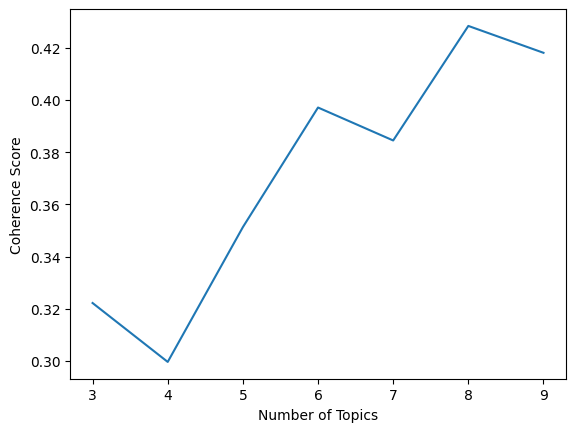

In [150]:
plot_coherence(Abarth_C)

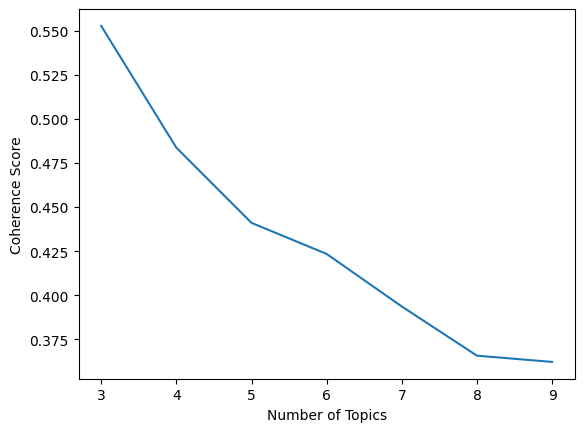

In [151]:
plot_coherence(Fiat_C)

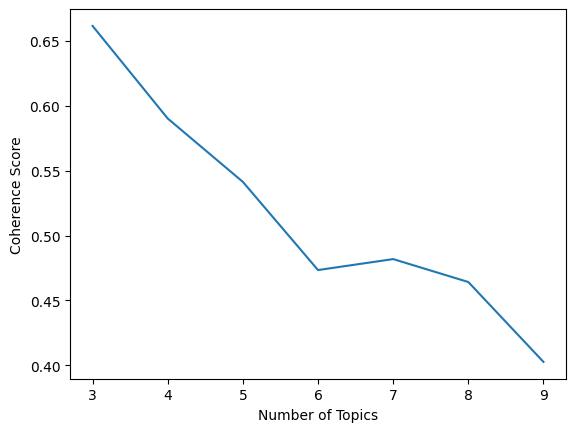

In [152]:
plot_coherence(Tesla_C)

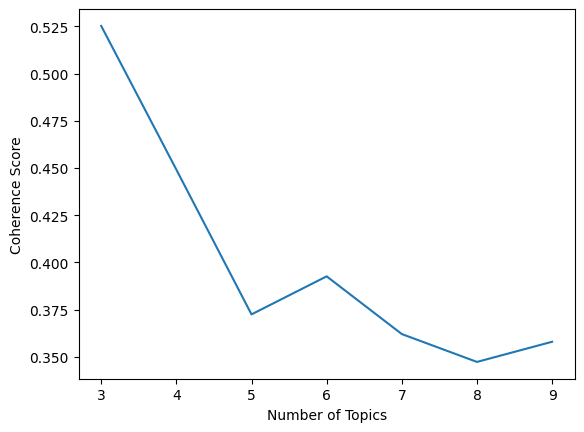

In [153]:
plot_coherence(Mini_C)

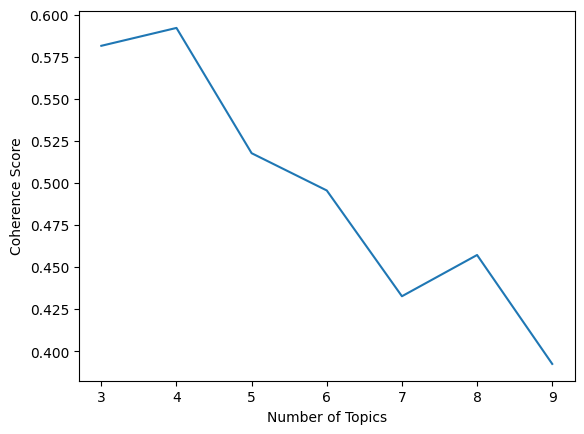

In [154]:
plot_coherence(Volk_C)

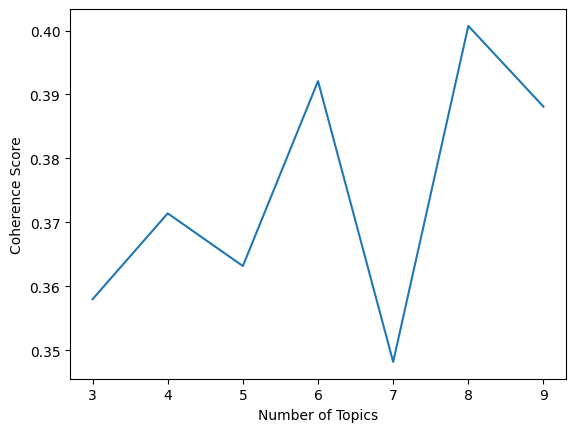

In [155]:
plot_coherence(Peugeot_C)

Pyldavis Visualisation and top comments for each topics

In [156]:
# Get the document-to-topic probabilities
def get_document_to_topic(model, corpus):
    doc_to_topic = []
    for doc in corpus:
        topics = model.get_document_topics(doc, minimum_probability=0)
        doc_topics = [prob for _, prob in topics]
        doc_to_topic.append(doc_topics)
    return pd.DataFrame(doc_to_topic)

# Get the top 3 comments for each topic
def print_top_comments_for_topics(model, doc_to_topic, original_comments):
    num_topics = len(model.show_topics())
    for topic_num in range(num_topics):
        top_comments_idx = doc_to_topic.nlargest(3, topic_num).index
        print(f"Topic {topic_num}:")
        print(model.show_topic(topic_num))
        print("Top 3 Comments:")
        for idx in top_comments_idx:
            print(" ".join(original_comments[idx]))
        print("="*40)

In [157]:
Abarth_doc_to_topic = get_document_to_topic(Abarth_lda_model, Abarth_corpus)
print_top_comments_for_topics(Abarth_lda_model, Abarth_doc_to_topic, Abarth_comments)

Topic 0:
[('sound', 0.05947204), ('ev', 0.05600199), ('engine', 0.043213736), ('electric', 0.041806832), ('drive', 0.02905907), ('range', 0.025657566), ('noise', 0.020938532), ('use', 0.020325521), ('price', 0.01588993), ('version', 0.012181954)]
Top 3 Comments:
stupid ok sound electric let electric motor sound electric motors emitt sound build purpose artificial sound kind fake electric sound mask ice old sf movies artificial sound aww
understand stupid potential buyer sport electric look noise gear smell petrol turn list switch silence power ev manufacturer follow closely idiocy offer fake engine sound wonder pipe rear bumper produce steam cold thank review personal look hot chick
ice electric motor add fake ice noise noise sound kind electric ditch attractive point engine sound heavier add fake combustion engine noise wrong
Topic 1:
[('small', 0.044910975), ('sell', 0.022402307), ('cool', 0.020639447), ('light', 0.015376544), ('performance', 0.015149369), ('road', 0.014202561), ('cu

In [159]:
Fiat_doc_to_topic = get_document_to_topic(Fiat_lda_model, Fiat_corpus)
print_top_comments_for_topics(Fiat_lda_model, Fiat_doc_to_topic, Fiat_comments)

Topic 0:
[('look', 0.028959634), ('good', 0.027121732), ('drive', 0.01860802), ('buy', 0.018180741), ('battery', 0.013705913), ('charge', 0.013222567), ('mile', 0.012516167), ('nice', 0.011197529), ('year', 0.0105939945), ('model', 0.007818732)]
Top 3 Comments:
obsession grey look depressing blend road colour dusk dawn safe interior depressing lead obsession dull dull grey alpha male ie try look cool actually demonstrate total lack imagination respect look toy look completely date couple year inch alloy ride uncomfortable alpha male preference purpose electrically operate door opening system break outside stick electrically operate stuff ensure future fail
year today stopping radar stupid fools cell year company stop sell eat hat hydrogen dirty water green hydrogen clean hydrogen dirty company fail year company fail far company alive past year
italians sure design beautifully problem build quality having punto bravo assure literally fall apart year absolute shame design beautifully bui

In [160]:
Mini_doc_to_topic = get_document_to_topic(Mini_lda_model, Mini_corpus)
print_top_comments_for_topics(Mini_lda_model, Mini_doc_to_topic, Mini_comments)

Topic 0:
[('small', 0.021213334), ('lot', 0.013760595), ('engine', 0.0126851), ('build', 0.010344629), ('weight', 0.008910926), ('quality', 0.008581787), ('probably', 0.00854132), ('point', 0.008114633), ('matt', 0.007929414), ('bit', 0.007881397)]
Top 3 Comments:
happen warning instant catch guard god ie flood sodom gomorrah rude awakening exact day hour rapture happen certainty rapture happen doubt revival usa worldwide lead soul turn christ jesus sure rapture happen soul bring christ jesus protection day sure yes year convert hour quickly rapture highly likely happen anytime year year max table run gods plan gentile christian accord line reference biblical event weather catastrophe war etc jewish variable ie temple construction red heifer bear sacrifice soon etc rapture happen mistake rapture happen true church christ jesus christ church earth close believe million disappear trace aunt uncle friend etc happen awake christ jesus hope find true later late life heart christ jesus real 

In [161]:
Tesla_doc_to_topic = get_document_to_topic(Tesla_lda_model, Tesla_corpus)
print_top_comments_for_topics(Tesla_lda_model, Tesla_doc_to_topic, Tesla_comments)

Topic 0:
[('use', 0.037585404), ('battery', 0.03259672), ('power', 0.025071196), ('water', 0.017691772), ('charge', 0.01588262), ('run', 0.01385243), ('love', 0.013056186), ('tank', 0.010831819), ('station', 0.009565415), ('range', 0.0091591375)]
Top 3 Comments:
topic find interesting device end creation nuclear waist step calculate energy pump electric motor vertically position circular platter magnet bed horizontally leave push force push sideways relative vertically spin disc spin fast sure magnet shield metal high permeability magnetic field emit focus fully sideways step calculate set copper coil interact magnetic field achieve perpetuate electrical current flow step build round horizontally position platter cover copper coil point stationary step build round platter cover powerful magnet point spin place directly platter hang copper coil step position vertical platter motorize close horizontally position platter cover magnet point vertically position platter spin bedded horizonta

In [162]:
Volk_doc_to_topic = get_document_to_topic(Volkswagen_lda_model, Volkswagen_corpus)
print_top_comments_for_topics(Volkswagen_lda_model, Volk_doc_to_topic, Volkswagen_comments)

Topic 0:
[('drive', 0.031486608), ('software', 0.014268217), ('golf', 0.012563694), ('great', 0.012536833), ('lot', 0.010742421), ('bad', 0.009522629), ('family', 0.00910571), ('seat', 0.008367275), ('update', 0.008036238), ('far', 0.007637337)]
Top 3 Comments:
bad gear video cover audience renault space family driver purpose mpv passenger driver option arguably combi original renault space bring future passenger mention safety beat opinion drive seat rear include row airbag air vent seat reclining flat leg space mention gorgeous huge sky run roof mercedes class choice passenger
diesel power generally fuel economy equivalent gasoline engine produce greenhouse gas emission great economy high energy litre content diesel fuel intrinsic efficiency diesel engine petrodiesel high density result high greenhouse gas emission litre compare gasoline fuel economy achieve modern diesel engine automobile offset high litre emission greenhouse gas diesel power emit percent greenhouse gas comparable g

In [163]:
Peugeot_doc_to_topic = get_document_to_topic(Peugeot_lda_model, Peugeot_corpus)
print_top_comments_for_topics(Peugeot_lda_model, Peugeot_doc_to_topic, Peugeot_comments)

Topic 0:
[('love', 0.104559965), ('big', 0.030684), ('wheel', 0.022973599), ('hope', 0.019912388), ('definitely', 0.017387135), ('great_review', 0.017222691), ('wow', 0.01685498), ('non', 0.015539124), ('line', 0.0146288425), ('year_old', 0.0124953)]
Top 3 Comments:
minute look manual pdf trip meter classify optional information total distance permanent information variable location depend view mode use press settings select configuration connect radio options connect nav instrument panel personalisation select personal personal select information ie trip computer save exit use personal personal mode
seriously consider tick box wheel drive good ground clearance road flood current problem prompt check local dealer wade depth reply deep ok cross list cross country estate rang dealer question reply mm away look person country drive flood water handle shallow flood look deceive chelsea tractor ambiguous suv guess
hope pencil pusher freight company pay attention news item class replacement 

In [164]:
# Visualize Abarth model
Abarth_vis = gensimvis.prepare(Abarth_lda_model, Abarth_corpus, Abarth_id2word)
pyLDAvis.display(Abarth_vis)

In [165]:
# Visualize Fiat model
Fiat_vis = gensimvis.prepare(Fiat_lda_model, Fiat_corpus, Fiat_id2word)
pyLDAvis.display(Fiat_vis)

In [166]:
# Visualize Tesla model
Tesla_vis = gensimvis.prepare(Tesla_lda_model, Tesla_corpus, Tesla_id2word)
pyLDAvis.display(Tesla_vis)

In [167]:
# Visualize Mini model
Mini_vis = gensimvis.prepare(Mini_lda_model, Mini_corpus, Mini_id2word)
pyLDAvis.display(Mini_vis)

In [168]:
# Visualize Volkswagen model
Volkswagen_vis = gensimvis.prepare(Volkswagen_lda_model, Volkswagen_corpus, Volkswagen_id2word)
pyLDAvis.display(Volkswagen_vis)

In [169]:
# Visualize Peugeot model
Peugeot_vis = gensimvis.prepare(Peugeot_lda_model, Peugeot_corpus, Peugeot_id2word)
pyLDAvis.display(Peugeot_vis)